In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle
import time

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-22 21:02:46.656922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 21:02:47.361346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
Num GPUs Available:  4


In [3]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId", 
            "DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId"]

print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [4]:
# DMesons_df = generate_df(DMesonsTTree, branches, 0)
# DMesons_df = apply_cuts(DMesons_df)
# DMesons_df

In [9]:
# Lambda_df = generate_df(LambdaMesonsTTree, branches, 0)
# Lambda_df = apply_cuts(Lambda_df)
# Lambda_df

In [ ]:
DMesons_df = load("DMesons_df")
Lambda_df = load("Lambda_df")

In [7]:
DMesons_df = remove_duplicates(DMesons_df)
Lambda_df = remove_duplicates(Lambda_df)

Removed 817956 duplicate particles
Removed 182504 duplicate particles


In [8]:
save(DMesons_df, "DMesons_df")
save(Lambda_df, "Lambda_df")

In [9]:
DMesons_df = DMesons_df.head(1000000)
Lambda_df = Lambda_df.head(1000000)

In [13]:
#separates each particle of the event into it's own event in a new data frame (for training)
def separate(df):
    dfs = []
    for index, row in df.iterrows():

        #reco Ds
        pts = row['DMesons_pt']
        etas = row['DMesons_eta']
        ms = row['DMesons_m']
        lxys = row['DMesons_fitOutput__Lxy']
        costhetastars = row['DMesons_costhetastar']
        pdgids = row["DMesons_pdgId"]

        #reco Ds Daughter info
        daughter_pts = row["DMesons_daughterInfo__pt"]
        daughter_etas = row["DMesons_daughterInfo__eta"]
        daughter_phis = row["DMesons_daughterInfo__phi"]
        daughter_pdgIds = row["DMesons_daughterInfo__pdgId"]

        d = {df.columns[0]: pts, df.columns[1]: etas, df.columns[2]: ms, df.columns[3]: lxys, 
             df.columns[4]: costhetastars, df.columns[5]: pdgids, 

             df.columns[6]: daughter_pts, df.columns[7]: daughter_etas, df.columns[8]: daughter_phis, 
             df.columns[9]: daughter_pdgIds}
        df = pd.DataFrame(data=d)

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.reset_index(drop = True)
    return df

In [14]:
DMesons_df = separate(DMesons_df)
Lambda_df = separate(Lambda_df)

In [21]:
# save(DMesons_df, "DMesons_df_separated")
# save(Lambda_df, "Lambda_df_separated")

In [17]:
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId
0,10.047125,0.081824,1862.417603,2.339530,0.254870,411,"[6.094892978668213, 1.3074619770050049, 2.7334...","(0.15998553, 0.011107716, -0.0614343)","(2.6128821, 2.7195172, 2.9228168)","(-321, 211, 211)"
1,18.993742,-1.661963,1853.906250,1.918414,-0.367302,411,"[6.457057952880859, 5.970093250274658, 6.63757...","(-1.608788, -1.6307458, -1.7315177)","(-0.371787, -0.5164238, -0.4971406)","(-321, 211, 211)"
2,18.993742,-1.661963,2398.886963,1.918414,-0.065073,4122,"[6.605627059936523, 6.457057952880859, 5.96782...","(-1.7326077, -1.608788, -1.6305238)","(-0.49662885, -0.371787, -0.5161313)","(2212, -321, 211)"
3,10.118494,0.041659,1874.203125,2.890126,0.068331,411,"[3.7944977283477783, 3.3083105087280273, 3.065...","(-0.073717244, 0.22605924, -0.017923404)","(0.753864, 0.6827104, 0.920779)","(-321, 211, 211)"
4,10.118494,0.041659,2468.180664,2.890126,0.427697,4122,"[3.3083105087280273, 3.7944977283477783, 3.065...","(0.22605924, -0.073717244, -0.017923404)","(0.6827104, 0.753864, 0.920779)","(2212, -321, 211)"
...,...,...,...,...,...,...,...,...,...,...
12311805,14.818177,-2.147933,1836.099731,2.027027,-0.971258,411,"[1.9173336029052734, 2.842648983001709, 9.9930...","(-2.113649, -2.2985442, -2.1073382)","(0.43151262, 0.49383813, 0.481693)","(-321, 211, 211)"
12311806,14.818177,-2.147933,2165.724121,2.027027,-0.951718,4122,"[10.060656547546387, 1.9173336029052734, 2.895...","(-2.1074958, -2.113649, -2.2997785)","(0.48089376, 0.43151262, 0.4876941)","(2212, -321, 211)"
12311807,39.381430,1.550356,2210.866699,0.170655,-0.332907,4122,"[24.071563720703125, 10.633554458618164, 4.659...","(1.5733823, 1.5007609, 1.538371)","(2.7796612, 2.7453563, 2.716648)","(2212, -321, 211)"
12311808,11.423040,-0.485724,1854.315796,1.397025,0.976994,411,"[5.934463024139404, 3.874907970428467, 1.68537...","(-0.47340268, -0.5774017, -0.2857665)","(2.4528677, 2.554509, 2.2073567)","(-321, 211, 211)"


In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")
                    
len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [19]:
def count(df):
    D = 0
    Lambda = 0
    for pdgId in df["DMesons_pdgId"]:
        if pdgId == 411 or pdgId == 0:
            D+=1
        elif pdgId == 4122 or pdgId == 1:
            Lambda+=1
    return D, Lambda

count(DMesons_df)

(6280052, 6017574)

In [35]:
# Read
Lambda_only_4122 = load("Lambda_df_daughter_only_4122")
DMesons_only_411 = load("DMesons_daughter_only_4122")

In [ ]:
# DMesons_only_411['DMesons_pdgId'] = DMesons_only_411['DMesons_pdgId'].replace({4122: 411})

# DMesons_only_411

In [40]:
# Lambda_only_4122 = Lambda_only_4122.head(400000)
# DMesons_only_411 = DMesons_only_411.head(400000)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_411], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [136]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,particle_type,inv_mass1
0,24.527068,1.131899,0.811323,-0.966063,0,"[11.868159294128418, 4.692102909088135, 7.9855...","(1.1646894, 1.1318113, 1.0789925)","(0.6169152, 0.57123685, 0.5109106)","(2212, -321, 211)",only_411,None
1,8.225824,-0.443289,0.298676,-0.108421,0,"[3.4026901721954346, 2.4992988109588623, 2.399...","(-0.4605694, -0.2508572, -0.59451324)","(2.622584, 2.3633363, 2.326128)","(2212, -321, 211)",only_411,None
2,12.938731,1.060801,1.900389,0.784224,0,"[7.267314434051514, 4.619868278503418, 1.07285...","(0.977554, 1.1012715, 1.3675625)","(-2.4181755, -2.3717563, -2.1982896)","(2212, -321, 211)",only_411,None
3,11.697609,-0.655718,2.204151,0.356227,0,"[4.47972297668457, 5.667332649230957, 1.556354...","(-0.48620725, -0.7879102, -0.6172329)","(-2.858657, -2.898594, -2.9482126)","(2212, -321, 211)",only_411,None
4,55.838035,0.180121,17.340847,0.090482,0,"[36.3106689453125, 17.45347785949707, 2.082934...","(0.18834986, 0.15486996, 0.24531575)","(-0.7377661, -0.7312852, -0.6350184)","(2212, -321, 211)",only_411,None
...,...,...,...,...,...,...,...,...,...,...,...
799995,15.516514,0.714063,2.826575,0.273049,0,"[8.232580184936523, 6.693222522735596, 0.62542...","(0.7209104, 0.6642995, 1.0689352)","(-1.2051988, -1.0829825, -1.2942322)","(2212, -321, 211)",only_411,None
799996,9.094251,-1.335225,0.269657,-0.355618,1,"[5.278110980987549, 2.019252061843872, 1.82516...","(-1.2534069, -1.2452421, -1.6080753)","(2.161675, 2.0766578, 2.3259208)","(2212, -321, 211)",only_4122,None
799997,9.131988,0.041091,0.329407,0.611082,1,"[2.460777759552002, 4.995091915130615, 1.70874...","(0.12101391, -0.055287715, 0.20483322)","(0.3058112, 0.32780313, 0.10899325)","(2212, -321, 211)",only_4122,None
799998,8.865642,-0.804682,0.852494,0.555877,0,"[3.251980781555176, 2.3899216651916504, 3.2291...","(-0.96728534, -0.8550701, -0.5743243)","(-2.970206, -3.087664, -3.0605102)","(2212, -321, 211)",only_411,None


In [145]:
shuffled_df_daughter = shuffled_df[["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"]]

In [293]:
#separate the daughter info
daughter_pts = []
daughter_etas = []
daughter_phis = []

for index, row in shuffled_df_daughter.iterrows():

    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    
    for pt, eta, phi in zip(pts, etas, phis):
        daughter_pts.append(pt)
        daughter_etas.append(etas)
        daughter_phis.append(phis)

In [294]:
len(daughter_pts)

2400000

In [300]:
particle1_pt = []
particle2_pt = []
particle3_pt = []

for i in range(0, len(daughter_pts), 3):
    particle1_pt.append(daughter_pts[i])
    particle2_pt.append(daughter_pts[i+1])
    particle3_pt.append(daughter_pts[i+2])

In [263]:
#this is for testing
for index, row in shuffled_df.iterrows():
    if index == 1:
        break
    pts = row['DMesons_daughterInfo__pt']
    pdgids = row["DMesons_pdgId"]
    types = row["particle_type"]
    if pdgids == 0:
        print("D")
    else:
        print("Lambda")
    for pt in zip(pts):
        print(pt)

D
(11.868159294128418,)
(4.692102909088135,)
(7.985586166381836,)


In [199]:
k_mass = 0.493677 #Gev/c^2
pi_mass = 0.13957 #Gev/c^2
p_mass = 0.938 #Gev/c^2

def createTLorentzVectors(df):
    TLorentzVectorList = []
    
    for index, row in df.iterrows():
        pts = row['DMesons_daughterInfo__pt']
        etas = row['DMesons_daughterInfo__eta']
        phis = row['DMesons_daughterInfo__phi']
        pdgids = row['DMesons_daughterInfo__pdgId']
        types = row["particle_type"]
        
        def assign_mass():
            if types == "only_411":
                #assume proton is pion
                return pi_mass
            elif types == "only_4122":
                #keep proton as proton
                return p_mass
            else:
                return pi_mass
            
        for pt, eta, phi, pdgid in zip(pts, etas, phis, pdgids):
            if pdgid == 211:
                m = pi_mass
            elif pdgid == -321:
                m = k_mass
            elif pdgid == 2212:
                m = assign_mass()
            else:
                continue

            p = ROOT.TLorentzVector()
            p.SetPtEtaPhiM(pt, eta, phi, m)
            TLorentzVectorList.append(p)

    return TLorentzVectorList

inv_mass_squared = lambda p1, p2: (p1 + p2).M2()

In [200]:
LorentzVectors = createTLorentzVectors(shuffled_df_daughter)
reshaped_list = [LorentzVectors[i:i+3] for i in range(0, len(LorentzVectors), 3)]
np.shape(reshaped_list)

In [228]:
inv_combo1 = []
inv_combo2 = []
for sublist in reshaped_list:
    inv_combo1.append(inv_mass_squared(sublist[0], sublist[1]))
    inv_combo2.append(inv_mass_squared(sublist[1], sublist[2]))
    
shuffled_df['inv_mass1'] = inv_combo1
shuffled_df['inv_mass2'] = inv_combo2

In [309]:
invmass_ready_df = shuffled_df.drop(['DMesons_daughterInfo__pt', 'DMesons_daughterInfo__eta', "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"], axis=1)
invmass_ready_df["daughter_pt1"] = particle1_pt
invmass_ready_df["daughter_pt2"] = particle2_pt
invmass_ready_df["daughter_pt3"] = particle3_pt
# invmass_ready_df["daughter_etas"] = daughter_etas
# invmass_ready_df["daughter_phis"] = daughter_phis
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,inv_mass1,inv_mass2,daughter_pt1,daughter_pt2,daughter_pt3
0,24.527068,1.131899,0.811323,-0.966063,0,1.079725,0.913237,11.868159,4.692103,7.985586
1,8.225824,-0.443289,0.298676,-0.108421,0,1.573671,1.270641,3.402690,2.499299,2.399992
2,12.938731,1.060801,1.900389,0.784224,0,1.211604,0.903373,7.267314,4.619868,1.072857
3,11.697609,-0.655718,2.204151,0.356227,0,2.823970,0.681484,4.479723,5.667333,1.556354
4,55.838035,0.180121,17.340847,0.090482,0,1.519394,1.087278,36.310669,17.453478,2.082934
...,...,...,...,...,...,...,...,...,...,...
799995,15.516514,0.714063,2.826575,0.273049,0,1.587042,1.331171,8.232580,6.693223,0.625421
799996,9.094251,-1.335225,0.269657,-0.355618,1,2.176403,1.300135,5.278111,2.019252,1.825164
799997,9.131988,0.041091,0.329407,0.611082,1,3.357666,1.391840,2.460778,4.995092,1.708745
799998,8.865642,-0.804682,0.852494,0.555877,0,0.839232,1.174328,3.251981,2.389922,3.229151


In [310]:
# create a new column 'particle_type' based on the pdgId column
def func(x):
    if x == 0:
        return 'only_411'
    elif x == 1:
        return 'only_4122'

invmass_ready_df['particle_type'] = invmass_ready_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_411']
only_4122 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_4122']

new_df = invmass_ready_df[invmass_ready_df['particle_type'] != 'both']
new_df = new_df.reset_index(drop=True)
only_411 = only_411.reset_index(drop=True)
only_4122 = only_4122.reset_index(drop=True)

# new_df.loc[:, 'DMesons_pt'] = new_df['DMesons_pt'].apply(lambda x: float(x))
# new_df.loc[:, 'DMesons_eta'] = new_df['DMesons_eta'].apply(lambda x: float(x))
# #new_df.loc[:, 'DMesons_m'] = new_df['DMesons_m'].apply(lambda x: float(x))
# new_df.loc[:, 'DMesons_fitOutput__Lxy'] = new_df['DMesons_fitOutput__Lxy'].apply(lambda x: float(x))
# new_df.loc[:, 'DMesons_costhetastar'] = new_df['DMesons_costhetastar'].apply(lambda x: float(x))
# new_df.loc[:, 'DMesons_pdgId'] = new_df['DMesons_pdgId'].apply(lambda x: int(x))
# new_df = new_df.drop('particle_type', axis=1)

In [317]:
new_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,inv_mass1,inv_mass2,daughter_pt1,daughter_pt2,daughter_pt3
0,24.527068,1.131899,0.811323,-0.966063,0,1.079725,0.913237,11.868159,4.692103,7.985586
1,8.225824,-0.443289,0.298676,-0.108421,0,1.573671,1.270641,3.402690,2.499299,2.399992
2,12.938731,1.060801,1.900389,0.784224,0,1.211604,0.903373,7.267314,4.619868,1.072857
3,11.697609,-0.655718,2.204151,0.356227,0,2.823970,0.681484,4.479723,5.667333,1.556354
4,55.838035,0.180121,17.340847,0.090482,0,1.519394,1.087278,36.310669,17.453478,2.082934
...,...,...,...,...,...,...,...,...,...,...
799995,15.516514,0.714063,2.826575,0.273049,0,1.587042,1.331171,8.232580,6.693223,0.625421
799996,9.094251,-1.335225,0.269657,-0.355618,1,2.176403,1.300135,5.278111,2.019252,1.825164
799997,9.131988,0.041091,0.329407,0.611082,1,3.357666,1.391840,2.460778,4.995092,1.708745
799998,8.865642,-0.804682,0.852494,0.555877,0,0.839232,1.174328,3.251981,2.389922,3.229151


In [316]:
only_411 = only_411.drop('particle_type', axis=1)
only_4122 = only_4122.drop('particle_type', axis=1)
new_df = new_df.drop("particle_type", axis=1)

# new_df = new_df.drop('DMesons_m', axis=1)
# only_411 = only_411.drop('DMesons_m', axis=1)
# only_4122 = only_4122.drop('DMesons_m', axis=1)

In [2]:
new_df = load("new_df_invmassdaughter_train")
only_411 = load("only_411_invmassdaughter_train")
only_4122 = load("only_4122_invmassdaughter_train")

In [3]:
#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', "inv_mass1", "inv_mass2", "daughter_pt1", "daughter_pt2", "daughter_pt3"]], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', "inv_mass1", "inv_mass2", "daughter_pt1", "daughter_pt2", "daughter_pt3"]], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', "inv_mass1", "inv_mass2", "daughter_pt1", "daughter_pt2", "daughter_pt3"]], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [4]:
print(np.shape(X_train), np.shape(X_test))

X_train

(640000, 9) (160000, 9)


,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,inv_mass1,inv_mass2,daughter_pt1,daughter_pt2,daughter_pt3
52811,37.341957,-0.528279,0.876727,-0.163480,4.518268,0.702809,21.327976,13.058212,2.985367
475516,10.641498,0.914045,1.398162,-0.883737,2.853040,0.601430,8.514012,1.105939,1.071738
122130,16.043410,1.799062,1.490950,0.041954,2.390576,0.721188,7.291071,5.717253,3.109725
701379,10.472263,1.742398,1.960363,0.656921,0.873924,1.177726,4.955917,3.317139,2.233912
672853,14.434020,0.478544,0.039826,-0.310774,3.532396,0.761318,8.966787,3.636620,1.890443
...,...,...,...,...,...,...,...,...,...
259178,24.471102,0.692326,16.075277,0.851681,0.851062,1.086836,13.109108,8.137378,3.266880
365838,15.827591,1.858487,0.805613,0.897850,1.239740,0.862968,6.595619,5.878557,3.362446
131932,14.238630,1.086133,0.024208,-0.168405,3.284802,0.578912,8.691536,3.300015,2.255589
671155,14.102196,-0.196168,1.214006,0.507912,2.005985,0.636198,4.648983,6.021185,3.440078


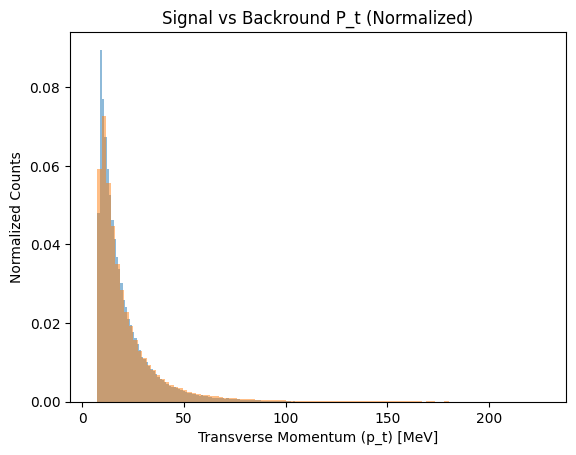

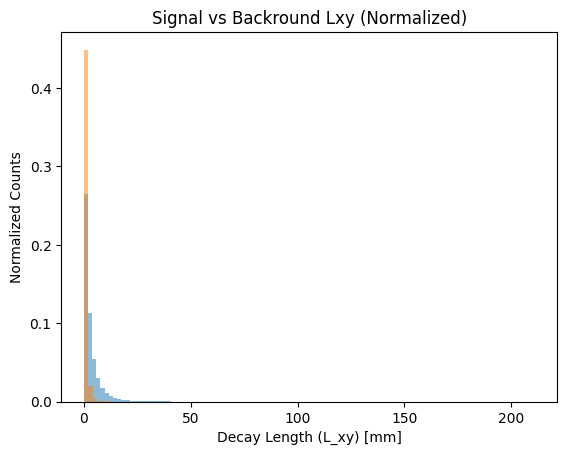

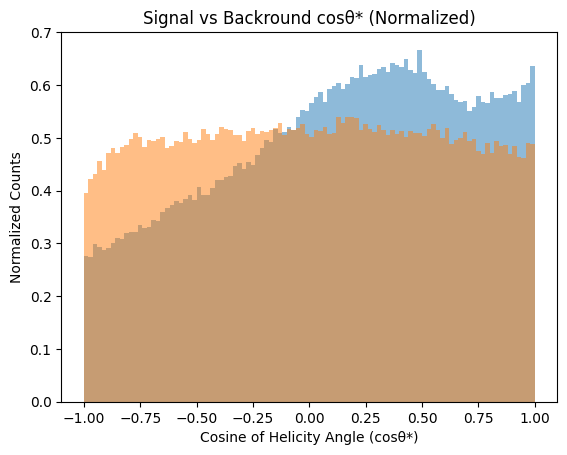

In [322]:
counts, bins, _ = plt.hist(X_train1["DMesons_pt"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["DMesons_pt"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround P_t (Normalized)")
plt.xlabel("Transverse Momentum (p_t) [MeV]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround Lxy (Normalized)")
plt.xlabel("Decay Length (L_xy) [mm]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_costhetastar"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["DMesons_costhetastar"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround cosθ* (Normalized)")
plt.xlabel("Cosine of Helicity Angle (cosθ*)")
plt.ylabel("Normalized Counts")
plt.show()

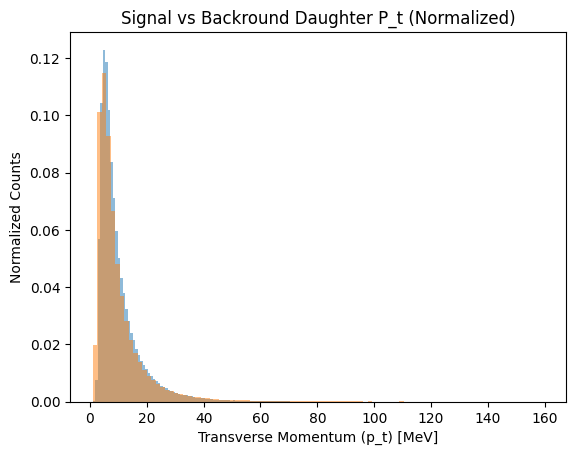

In [361]:
counts, bins, _ = plt.hist(X_train1["daughter_pt1"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["daughter_pt1"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround Daughter P_t (Normalized)")
plt.xlabel("Transverse Momentum (p_t) [MeV]")
plt.ylabel("Normalized Counts")
plt.show()

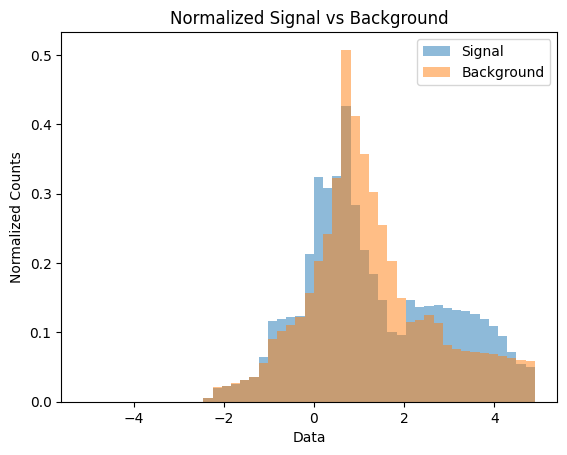

In [323]:
#counts, bins, _ = plt.hist(X_train1, bins=20)
bins = np.linspace(-5, 5, 50)
signal_counts, _ = np.histogram(X_train2, bins=bins, density=True)
background_counts, _ = np.histogram(X_train1, bins=bins, density=True)

# Plot the signal and background histograms on the same plot
plt.bar(bins[:-1], signal_counts, width=np.diff(bins), alpha=0.5, label='Signal')
plt.bar(bins[:-1], background_counts, width=np.diff(bins), alpha=0.5, label='Background')

# Add axis labels and a legend
plt.xlabel('Data')
plt.ylabel('Normalized Counts')
plt.title("Normalized Signal vs Background")
plt.legend()

# Show the plot
plt.show()

In [5]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 64,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 32,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 50,
        "batch_size": 32
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh (atlasdnn). Use `wandb login --relogin` to force relogin


In [6]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred): 
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  640       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  2080      
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


2023-04-22 18:09:24.871976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38168 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-04-22 18:09:24.873718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38168 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-04-22 18:09:24.875223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38168 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2023-04-22 18:09:24.876671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38168 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [ ]:
#Compile
start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
#Train
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

In [346]:
wandb.finish()

custom_accuracy,▁▆▇▇▇▇▇█████████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_custom_accuracy,▂▅▁▇▆▆▆▇▆▇▇██▇▇▆
val_loss,█▅▇▃▃▃▄▂▄▄▁▂▁▁▂▃
best_epoch,12
best_val_loss,0.02634
custom_accuracy,0.98331
epoch,15
loss,0.04768
val_custom_accuracy,0.98723


------------------------------------------ Finished training, now analyze ------------------------------------------

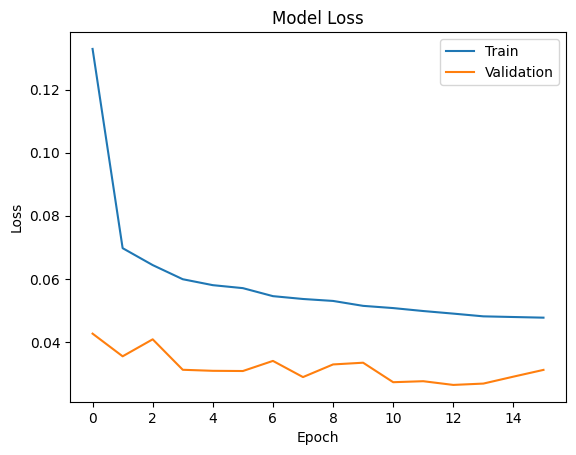

In [347]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [348]:
predictions_both = model.predict(X_test)
predictions_both[:10]

5000/5000 [==============================] - 5s 1ms/step


array([[7.1088782e-25],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.6372047e-19],
       [9.9999988e-01],
       [5.7209105e-25],
       [9.9998599e-01],
       [1.3263221e-11],
       [5.5904919e-01]], dtype=float32)

In [349]:
predictions_background = model.predict(X_test1)
predictions_background[:10]

2500/2500 [==============================] - 3s 1ms/step


array([[7.0275242e-08],
       [7.6552309e-22],
       [1.2576581e-16],
       [4.6907729e-03],
       [3.8948545e-32],
       [4.5645117e-28],
       [3.2628909e-02],
       [2.9678710e-30],
       [1.7343564e-11],
       [1.5058629e-31]], dtype=float32)

In [350]:
predictions_signal = model.predict(X_test2)
predictions_signal[:10]

2500/2500 [==============================] - 3s 1ms/step


array([[1.        ],
       [1.        ],
       [0.9999999 ],
       [0.9999999 ],
       [0.9317227 ],
       [0.99985236],
       [0.9987786 ],
       [0.99999905],
       [0.9999999 ],
       [0.9801107 ]], dtype=float32)

In [377]:
#predict accuract given y_test and predictions from model
def pred_accuracy(y_test, predictions):
    D_count, Lambda_count = 0, 0

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            Lambda_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            D_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    
    # print("$D^+$ Count: {}".format(D_count))
    # print("$\Lambda_C^+ Count: {}".format(Lambda_count))
    
    return accuracy

accuracy_both = pred_accuracy(y_test, list(predictions_both))
accuracy_background = pred_accuracy(y_test1, list(predictions_background))
accuracy_signal = pred_accuracy(y_test2, list(predictions_signal))

print("Accuracy for Both: {:.2%}".format(accuracy_both))
print("Accuracy for Only Background: {:.2%}".format(accuracy_background))
print("Accuracy for Only Signal: {:.2%}".format(accuracy_signal))

Accuracy for Both: 98.72%
Accuracy for Only Background: 98.18%
Accuracy for Only Signal: 99.43%


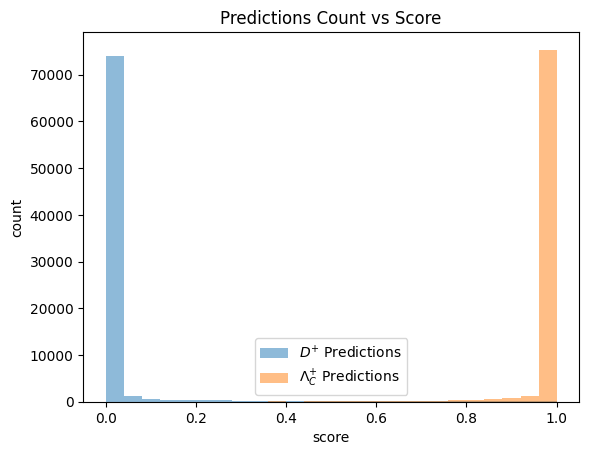

In [381]:
hist = plt.hist(predictions_background, bins = 25, label = "$D^{+}$ Predictions", alpha=0.5)
hist2 = plt.hist(predictions_signal, bins = 25, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.title("Predictions Count vs Score")
plt.legend()
plt.show()

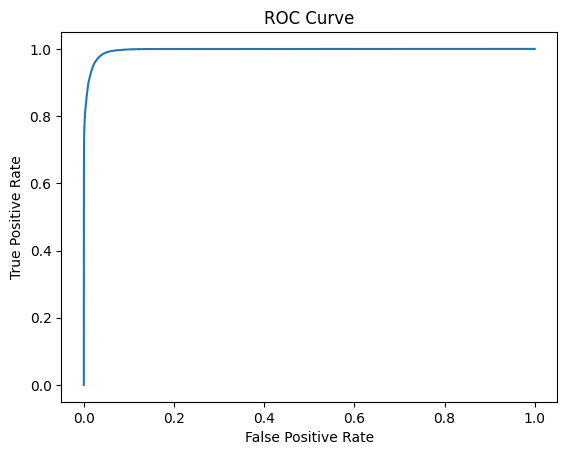

In [379]:
# Get true labels and predicted probabilities
y_true = list(y_test)
y_pred = predictions

# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()